In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
# from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
# import matplotlib; matplotlib.use("TkAgg")

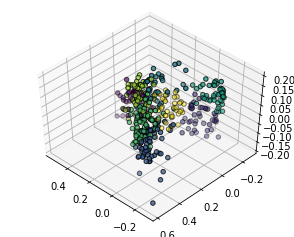

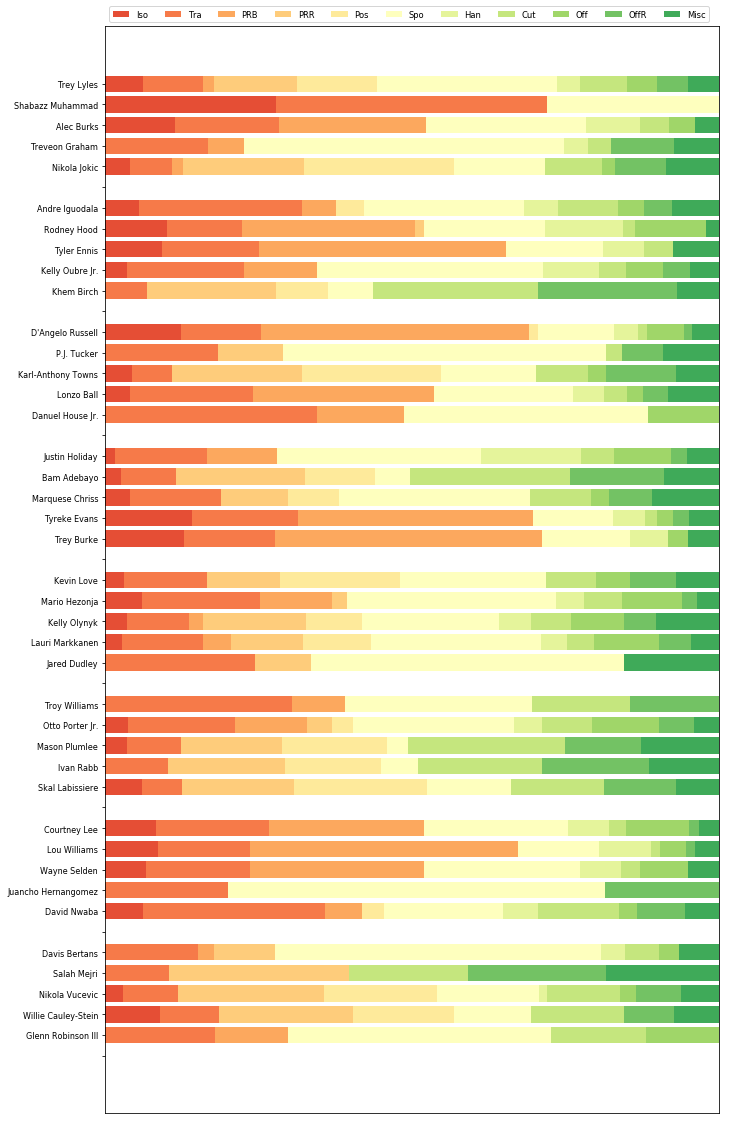

In [17]:
def pca_processing(fname, n_comp=3):
    '''
    Function to decrease the dimension of the players based on their POSS_PCT
    :param fname: the path of the pca_table file
    :param n_comp: the number of main components we want to use
    :return: data after pca with dimension n*n_comp; player names
    '''
    df = pd.read_csv(fname)
    kept_cols = [
        col for col in df.columns if col.endswith("freq")
    ]
    kept_cols.append("PLAYER_NAME")
    kept_cols.reverse()
    df = df[kept_cols]

    player_name = df["PLAYER_NAME"]
    data_org = df.iloc[:, 2:]
    pca = PCA(n_components=n_comp)
    pca.fit(data_org)
    data_pca = data_org @ pca.components_.T
    assert len(data_pca) == len(player_name)

    return data_pca, player_name


def k_means(fname, dim=3, cluster_num=5, show_img=False):
    '''
    Function to cluster the data into cluster_num groups and visualize them in a 3D space
    :param fname: the path of the pca_table file
    :param dim: the number of dimensions we want to use
    :param cluster_num: the number of clusters we want to cluster them
    :param show_img: show k-means image or not
    :return: NONE
    '''
    assert isinstance(fname, str)
    data, names = pca_processing(fname, dim)
    X = np.array(data)
    k_means = KMeans(n_clusters=cluster_num).fit(X)
    labels = k_means.labels_
    fig = plt.figure(1, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    ax.scatter(X[:, 1], X[:, 0], X[:, 2], c=labels.astype(np.float), edgecolor='k')
    if show_img is True:
        fig.show()
    distance = k_means.transform(X)
    return names, labels, distance


def calculate_top5(distance, names):
    '''
    Function to find the top5 players who are the most closest to the k-means's cluster center
    :param distance: Distance of each player to the clusters
    :param names: names of each player
    :return: top5 names of each clusters
    '''
    dim = len(distance[0])
    result = np.zeros((dim, 5))
    top5_name = []
    for i in range(dim):
        temp = []
        curr = np.array(distance[:, i])
        min_5 = curr.argsort()[:5]
        result[i, :] = min_5
        for index in min_5:
            temp.append(names[index])
        top5_name.append(temp)
    return top5_name


def top5_img(distance, names, year):
    '''
    :param distance: distance of player to kmeans center
    :param names: player names
    :param year: year
    :return: dictionary of player names and their play type
    '''
    assert 2015 <= year <= 2019
    top5names = calculate_top5(distance, names)
    path = "data/data_cleaned/pca_data/" + str(year) + "_pca_table.csv"
    df = pd.read_csv(path)
    data_per_player = np.zeros((1, 11))
    for i in range(len(top5names)):
        for j in range(len(top5names[i])):
            new_df = df[df['PLAYER_NAME'] == top5names[i][j]]
            data = new_df[
                ["iso_freq", "tr_freq", "prb_freq", "prr_freq", "pu_freq", "su_freq", "ho_freq", "cut_freq", "os_freq",
                 "putback_freq", "misc_freq"]]
            data = data.values.tolist()
            data = np.array(data)[0]
            data_per_player = np.vstack((data_per_player, data))
    data_per_player = data_per_player[1:,:]
    data_per_player = data_per_player / data_per_player.sum(axis=1, keepdims=True)
    # print(data_per_player.shape)
    result = {}
    for i in range(8):
        for j in range(5):
            result[top5names[i][j]] = data_per_player[i * 5 + j, :]
    return result

def survey(results):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
        The category labels.
    """
    category_names = ["Iso",
                      "Tra",
                      "PRB",
                      "PRR",
                      "Pos",
                      "Spo",
                      "Han",
                      "Cut",
                      "Off",
                      "OffR",
                      "Misc"]

    labels = list(results.keys())
    new_labels = []
    start = " "
    for i in range(len(labels)):
        new_labels.append(labels[i])
        if i % 5 == 4:
            new_labels.append(start)
            start += " "
    labels = new_labels
    data = np.array(list(results.values()))
    new_data = []
    for i in range(len(data)):
        new_data.append(data[i])
        if i % 5 == 4:
            new_data.append(np.zeros(shape=data[0].shape))
    data = np.array(new_data)

    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(11,20))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.barh(labels, widths, left=starts, height=0.8,
                label=colname, color=color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


names, labels, distance = k_means('data/data_cleaned/pca_data/2017_pca_table.csv', 3, 8)
results = top5_img(distance, names, 2017)
survey(results)
plt.show()

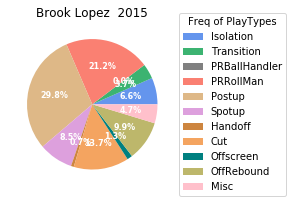

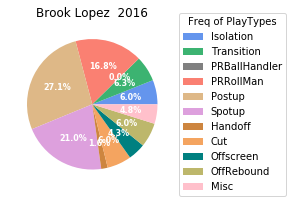

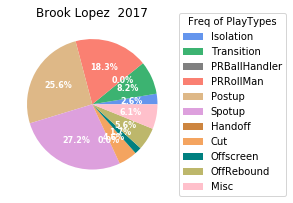

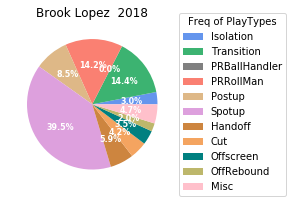

In [18]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct, absolute)


def draw_pie_chart(name, year):
    '''
    Function to draw the pie chart of players of different PlayType.
    Just input the player name and the year you want to know.
    :param name: Player name, string
    :param year: year
    :return:
    '''
    assert isinstance(name, str)
    assert 2015 <= year <= 2019
    path = "data/data_cleaned/pca_data/" + str(year) + "_pca_table.csv"
    df = pd.read_csv(path)
    new_df = df[df['PLAYER_NAME'] == name]
    data = new_df[["iso_freq", "tr_freq", "prb_freq", "prr_freq", "pu_freq", "su_freq", "ho_freq", "cut_freq", "os_freq",
                  "putback_freq", "misc_freq"]]
    data = data.values.tolist()
    data = np.array(data)[0]
    data = data / np.sum(data)
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    recipe = ["Isolation",
              "Transition",
              "PRBallHandler",
              "PRRollMan",
              "Postup",
              "Spotup",
              "Handoff",
              "Cut",
              "Offscreen",
              "OffRebound",
              "Misc"]
    ingredients = [x.split()[-1] for x in recipe]
    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                      textprops=dict(color="w"), shadow=False,
                                      colors=["cornflowerblue", "mediumseagreen", "gray", "salmon", "burlywood", "plum",
                                              "peru", "sandybrown", "teal", "darkkhaki", "pink"])
    ax.legend(wedges, ingredients,
              title="Freq of PlayTypes",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=8, weight="bold")

    ax.set_title(name + "  " + str(year))

    plt.show()
    return

for i in range(2015, 2019):
    draw_pie_chart("Brook Lopez", i)

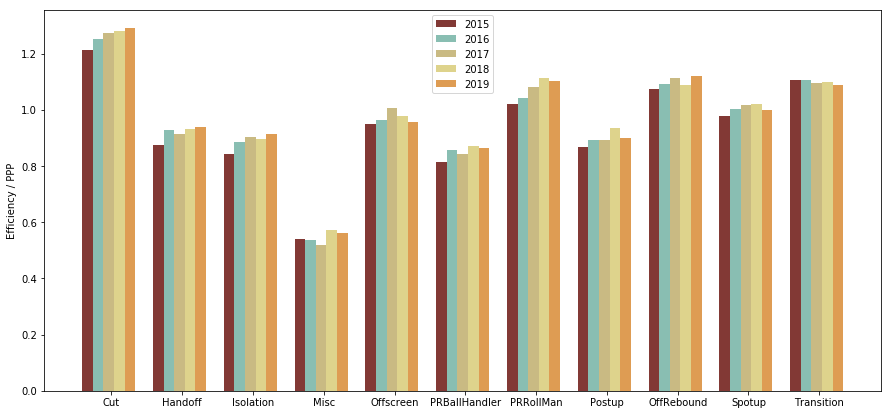

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.pull_nba_v2 import pull_nba
from src.nba_json_to_DF import json_to_DF
from collections import defaultdict


playtypes = ['cut', 'ho', 'iso', 'misc',
             'os', 'prb', 'prr', 'pu',
             'putback', 'su', 'tr']

playtype_shortcut = {'iso':'Isolation', 'tr':'Transition', 'prb':'PRBallHandler', 
                     'prr':'PRRollMan','pu':'Postup','su': 'Spotup', 
                     'ho':'Handoff','cut':'Cut', 'os':'Offscreen', 
                     'putback':'OffRebound', 'misc':'Misc'}


def get_plot_data(aggr_data=None):
    """
    param: aggr_data, str, where the yearly aggregated data is
    param: outdir, str, folder to store output figures
    return: plot_data, dictionary = {year: data list of the year}
    """

    assert aggr_data, "Input directory is invalid."

    files = os.listdir(aggr_data)
    plot_data = defaultdict(list)
    for f in files:
        df = pd.read_csv(
            os.path.join(aggr_data, f)
        )
        year = "".join(
            [c for c in f if '0' <= c <= '9']
        )
        year = int(year)


        for col in playtypes:
            df[col + "_pts"] = df[col + "_ppp"] * df[col + "_poss"]
        df_sum = df.sum()
        for col in playtypes:
            plot_data[year].append(
                df_sum[col + "_pts"] / df_sum[col + "_poss"]
            )
    return plot_data


def plot_most_effi_figure(aggr_data, outdir=None):
    """
    param: aggr_data, str, where the yearly aggregated data is
    param: outdir, str, folder to store output figures
    return: save figures in the outdir
    """
    if outdir and not os.path.exists(outdir):
        os.mkdir(outdir)

    plot_data = get_plot_data(aggr_data)
    x = np.arange(11, dtype=np.float64)
    bar_width, start = 0.15, x
    colors = ["#823935", "#89BEB2", "#C9BA83", "#DED38C", "#DE9C53"]
    
    plt.figure(figsize=(15, 7))
    for year in range(2015, 2020):
        plt.bar(
            start, 
            plot_data[year], 
            bar_width, 
            color=colors[year-2015], 
            label=str(year)
        )
        start += bar_width

    plt.legend(loc="upper center")
    plt.xticks(
        x - 5.5 * bar_width / 2, [playtype_shortcut[x] for x in playtypes]
    )
    plt.ylabel("Efficiency / PPP")
    plt.show() 


plot_most_effi_figure("data/data_cleaned/poss_ppp_data")